In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import typing

## helper functions

In [ ]:
def generate_packets_per_ms(df: pd.DataFrame):
  df_copy = df.copy()

  df_copy['frame_info_time_relative_str'] = "00:00:00." + df_copy['frame_info_time_relative'].astype(str)
  df_copy['frame_info_time_relative_str'] = pd.to_timedelta(df_copy['frame_info_time_relative_str'])
  df_copy = df_copy.set_index('frame_info_time_relative_str')

  # qualquer coluna serve
  resampled_df = df_copy.resample('1ms').count()

  resampled_df = resampled_df.reset_index()
  resampled_df['ms_groups'] = resampled_df['frame_info_time_relative_str'].dt.microseconds

  return resampled_df[['ms_groups', 'aaf_stream_id']]

def filter_dataframe(df: pd.DataFrame, filters: typing.Dict):
    filtered_df = df.copy()

    for column, values in filters.items():
        filtered_df = filtered_df[filtered_df[column].isin(values)]

    return filtered_df

def transform_data_into_channel_samples(row, n_samples: int = 6):
  channel_samples = []
  time_sample = row['aaf_avtp_timestamp']
  data_sample = row['aaf_data']

  transformed_data_sample = data_sample.replace(":", "")

  for i in range(n_samples):
    channel_0_start_index = 4*2*i
    channel_0_stop_index = 4*(2*i+1)
    channel_1_start_index = channel_0_stop_index
    channel_1_stop_index = 4*(2*(i+1))

    current_channel_0 = transformed_data_sample[channel_0_start_index:channel_0_stop_index]
    current_channel_1 = transformed_data_sample[channel_1_start_index:channel_1_stop_index]

    channel_samples.append([time_sample, current_channel_0, current_channel_1])

  return channel_samples


def apply_transformation_function(row):
  channel_samples = transform_data_into_channel_samples(row)

  return channel_samples


def expand_from_list(x):
  index = x['level_1']
  timestamp = x[0][0]
  channel_0 = x[0][1]
  channel_1 = x[0][2]

  return index, timestamp, channel_0, channel_1


def generate_channel_values_dataframe(df: pd.DataFrame):
  df_copy = df.copy()

  transformed_df = df_copy.apply(apply_transformation_function, axis=1, result_type='expand')
  transformed_df = transformed_df.stack().reset_index()
  transformed_df = transformed_df.apply(expand_from_list, axis=1, result_type='expand')
  # print(transformed_df)

  # essa difference nao pode ser hardcoded
  # pq se for hardcoded, na hora de plotar o sinal com ataque ele vai ajustar o sinal
  sampling_frequency = 48*10**3

  transformed_df["shifted_ts"] = transformed_df[1] - transformed_df[1][0]
  transformed_df["updated_shifted_ts"] = transformed_df["shifted_ts"] + (transformed_df[0] / sampling_frequency)*1000000000

  # transformed_df["updated_ts"] = transformed_df[1] + (transformed_df[0] / sampling_frequency)
  # transformed_df["relative_updated_ts"] = transformed_df["updated_ts"] - transformed_df["updated_ts"][0]
  transformed_df["channel_0_int"] = transformed_df[2].apply(lambda x: int(x, 16) if int(x, 16) <= 0x7FFF else int(x, 16) - 0x10000)
  transformed_df["channel_1_int"] = transformed_df[3].apply(lambda x: int(x, 16) if int(x, 16) <= 0x7FFF else int(x, 16) - 0x10000)

  return transformed_df

## main code

In [ ]:
tsn_box_dataset_folder_path = "/content/drive/MyDrive/Mestrado/Proposta de mestrado/Vehicle Sec 2024/processed_csv_files"
filepaths = glob.glob(f"{tsn_box_dataset_folder_path}/*.csv")

In [ ]:
columns_names = [
    "frame_info_time",
    "frame_info_offset_shift",
    "frame_info_time_epoch",
    "frame_info_time_delta",
    "frame_info_time_delta_displayed",
    "frame_info_time_relative",
    "frame_info_number",
    "frame_info_len",
    "eth_dst",
    "eth_src",
    "eth_type",
    "ieee1722_subtype",
    "aaf_seqnum",
    "aaf_stream_id",
    "aaf_avtp_timestamp",
    "aaf_format_info",
    "aaf_nominal_sample_rate",
    "aaf_channels_per_frame",
    "aaf_bit_depth",
    "aaf_stream_data_len",
    "aaf_sparse_timestamp",
    "aaf_data"
]

# 1000 samples for packets per ms
# n_samples_to_read = 1000
# 50 samples for interframe gap
# n_samples_to_read = 50
# 30 samples for aaf seq num diff
n_samples_to_read = 30

loaded_dfs_list = []
packet_per_time_df_list = []
channel_values_df_list = []

description_name = "Description"

for filepath in filepaths:
  # remover também a primeira row que não tem referência de pacote anterior
  df = pd.read_csv(filepath, header=None, names=columns_names, skiprows=2, nrows=n_samples_to_read)
  df_config = filepath.replace(f"{tsn_box_dataset_folder_path}/processed_", "")
  df_config = df_config.replace(".csv", "")
  df[description_name] = df_config
  df['aaf_seqnum_diff'] = df['aaf_seqnum'].diff()
  df['shifted_aaf_avtp_timestamp'] = df['aaf_avtp_timestamp'] - df['aaf_avtp_timestamp'][1]
  df['frame_info_time_delta'] = 1000000*df['frame_info_time_delta']

  packet_per_time_df = generate_packets_per_ms(df)
  packet_per_time_df[description_name] = df_config

  channels_df = generate_channel_values_dataframe(df)
  channels_df[description_name] = df_config

  loaded_dfs_list.append(df)
  packet_per_time_df_list.append(packet_per_time_df)
  channel_values_df_list.append(channels_df)

combined_df = pd.concat(loaded_dfs_list)
combined_df[description_name] = combined_df[description_name].str.replace("TSNBox_", "")
combined_df[description_name] = combined_df[description_name].str.replace("_None_None", "")

combined_packet_per_time_df = pd.concat(packet_per_time_df_list)
combined_packet_per_time_df[description_name] = combined_packet_per_time_df[description_name].str.replace("TSNBox_", "")
combined_packet_per_time_df[description_name] = combined_packet_per_time_df[description_name].str.replace("_None_None", "")

combined_channels_df = pd.concat(channel_values_df_list)
combined_channels_df[description_name] = combined_channels_df[description_name].str.replace("TSNBox_", "")
combined_channels_df[description_name] = combined_channels_df[description_name].str.replace("_None_None", "")

In [ ]:
combined_df[description_name] = combined_df[description_name].str.replace("Drop_1pkt_1ms", "Drop_1pkt_1000us")
combined_packet_per_time_df[description_name] = combined_packet_per_time_df[description_name].str.replace("Drop_1pkt_1ms", "Drop_1pkt_1000us")
combined_channels_df[description_name] = combined_channels_df[description_name].str.replace("Drop_1pkt_1ms", "Drop_1pkt_1000us")

In [ ]:
combined_packet_per_time_df[description_name].unique()

array(['Normal', 'TSJitter_25ns_500us', 'OoS_1pkt_500us',
       'Drop_1pkt_500us', 'OoS_3pkt_500us', 'Drop_1pkt_1000us',
       'Delay_3pkt_500us', 'TSJitter_25ns_125us', 'Delay_1pkt_500us'],
      dtype=object)

### Interframe gap per attack plots

Processing for index : 0


<ipython-input-10-1368885d5c06>:27: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.lineplot(data=second_filtered_dataframe, x="frame_info_time_relative", y="frame_info_time_delta", hue=description_column, linewidth=2, style=description_column, markers=True, markersize=10, ax=axes[index][1], palette=custom_palette)


Processing for index : 1


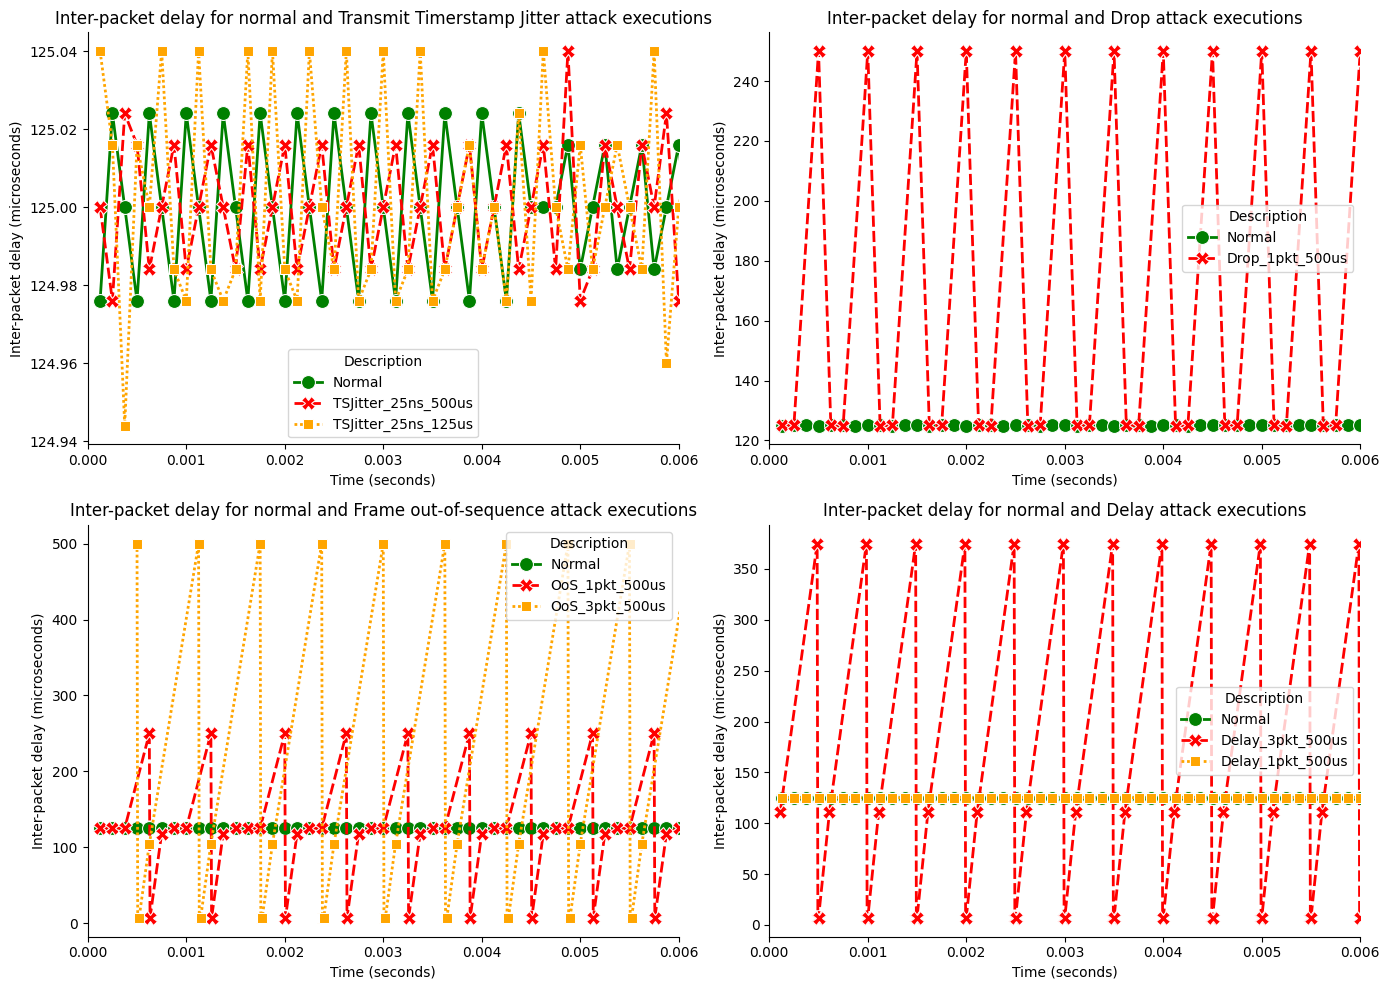

In [ ]:
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, (n_rows)*5))
description_column = description_name
custom_palette = ['green', 'red', 'orange']

attacks_filter = {
    "0": {"filter": {description_column : ["Normal", 'TSJitter_25ns_500us', 'TSJitter_25ns_125us']}, "attack": "Transmit Timerstamp Jitter"},
    "1": {"filter": {description_column : ["Normal", 'Drop_1pkt_500us', 'Drop_1pkt_1000us']}, "attack": "Drop"},
    "2": {"filter": {description_column : ["Normal", 'OoS_1pkt_500us', 'OoS_3pkt_500us']}, "attack": "Frame out-of-sequence"},
    "3": {"filter": {description_column : ["Normal", 'Delay_3pkt_500us', 'Delay_1pkt_500us']}, "attack": "Delay"}
}

for index in range(n_rows):
  print(f"Processing for index : {index}")
  filtered_dataframe = filter_dataframe(combined_df, attacks_filter[f"{2*index}"]["filter"])
  g = sns.lineplot(data=filtered_dataframe, x="frame_info_time_relative", y="frame_info_time_delta", hue=description_column, linewidth=2, style=description_column, markers=True, markersize=10, ax=axes[index][0], palette=custom_palette)
  axes[index][0].set_ylabel('Inter-packet delay (microseconds)')
  axes[index][0].set_xlabel('Time (seconds)')
  axes[index][0].spines['right'].set_visible(False)
  axes[index][0].spines['top'].set_visible(False)
  axes[index][0].set_title(f"Inter-packet delay for normal and {attacks_filter[f'{2*index}']['attack']} attack executions")
  axes[index][0].set_xlim(0, 0.006)


  second_filtered_dataframe = filter_dataframe(combined_df, attacks_filter[f"{2*index + 1}"]["filter"])
  g = sns.lineplot(data=second_filtered_dataframe, x="frame_info_time_relative", y="frame_info_time_delta", hue=description_column, linewidth=2, style=description_column, markers=True, markersize=10, ax=axes[index][1], palette=custom_palette)
  axes[index][1].set_ylabel('Inter-packet delay (microseconds)')
  axes[index][1].set_xlabel('Time (seconds)')
  axes[index][1].spines['right'].set_visible(False)
  axes[index][1].spines['top'].set_visible(False)
  axes[index][1].set_title(f"Inter-packet delay for normal and {attacks_filter[f'{2*index + 1}']['attack']} attack executions")
  axes[index][1].set_xlim(0, 0.006)

# Adjust layout
plt.tight_layout()

### Interframe gap unified plot

[Text(0.5, 0, 'Time (seconds)'), Text(0, 0.5, 'Interframe Gap (us)')]

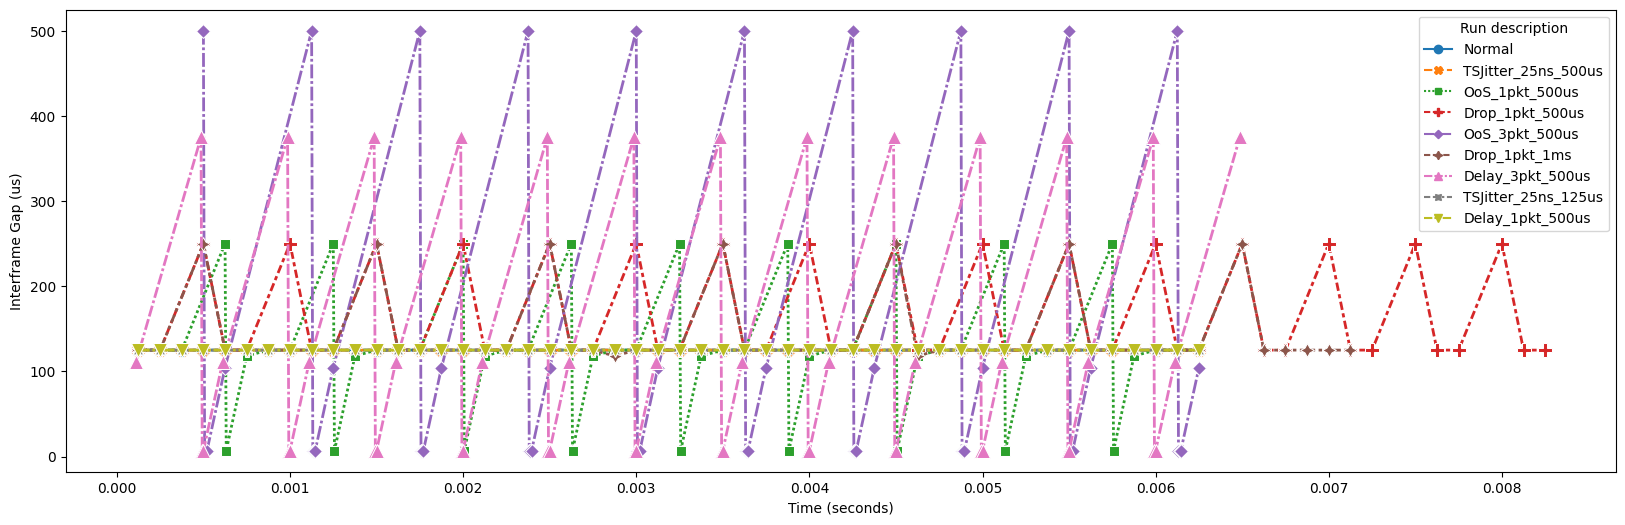

In [ ]:
n_rows = 1
fig, axes = plt.subplots(n_rows, 1, figsize=(20, (n_rows)*6))

# Interframe gap
axes = sns.lineplot(data=combined_df, x='frame_info_time_relative', y='frame_info_time_delta', hue=description_name, linewidth=2, style=description_name, markers=True, markersize=10)
axes.set(xlabel='Time (seconds)', ylabel='Interframe Gap (us)')

### Seq num difference plot

Text(0.5, 1.0, 'AAF Sequence Number Difference for Normal and Frame out-of-sequence attack executions')

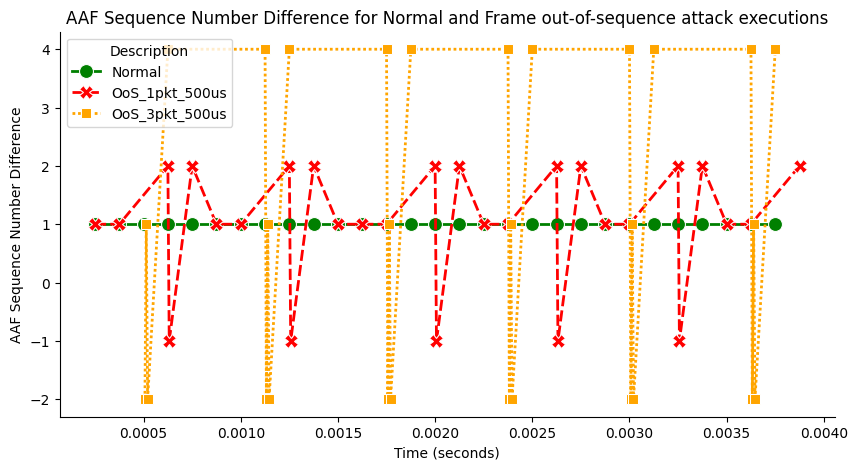

In [ ]:
normal_and_oos_filter = {
    description_name : ["Normal", 'OoS_1pkt_500us', 'OoS_3pkt_500us']
}

normal_and_oos_df = filter_dataframe(combined_df, normal_and_oos_filter)
normal_and_oos_df = normal_and_oos_df.dropna()
custom_palette = ['green', 'red', 'orange']

# Out of sequence difference
n_rows = 1
fig1, axes1 = plt.subplots(n_rows, 1, figsize=(10, (n_rows)*5))

axes1 = sns.lineplot(data=normal_and_oos_df, x='frame_info_time_relative', y='aaf_seqnum_diff', hue=description_name, style=description_name, palette=custom_palette, markers=True, markersize=10, linewidth=2)
axes1.set(xlabel='Time (seconds)', ylabel='AAF Sequence Number Difference')
# axes1.set_ylim(-5, +5)
axes1.spines['right'].set_visible(False)
axes1.spines['top'].set_visible(False)
axes1.set_title(f"AAF Sequence Number Difference for Normal and Frame out-of-sequence attack executions")

### Packets per unit of time plot

Text(0, 0.5, 'Throughput')

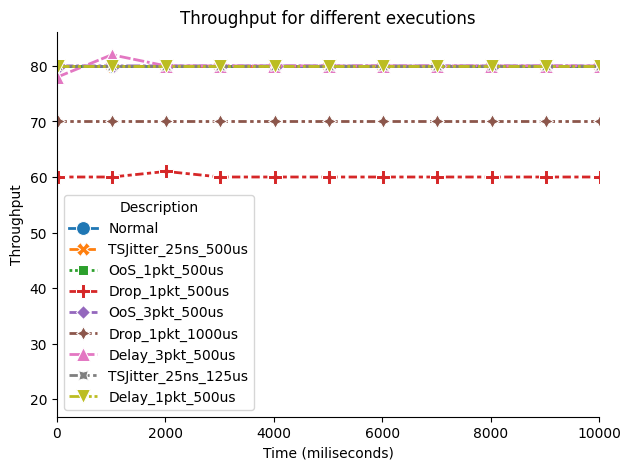

In [ ]:
# Out of sequence difference
n_rows = 1
fig2, axes2 = plt.subplots(n_rows, 1, figsize=(7, (n_rows)*5))

axes2 = sns.lineplot(data=combined_packet_per_time_df, x='ms_groups', y='aaf_stream_id', hue=description_name, style=description_name, markers=True, markersize=10, linewidth=2)
axes2.set(xlabel='Time (miliseconds)', ylabel='Packets per ms')
# axes2.set_ylim(-5, +5)
axes2.spines['right'].set_visible(False)
axes2.spines['top'].set_visible(False)
axes2.set_title(f"Throughput for different executions")
axes2.set_xlim(0, 10000)
axes2.set_ylabel("Throughput")

### Dropped packets plot

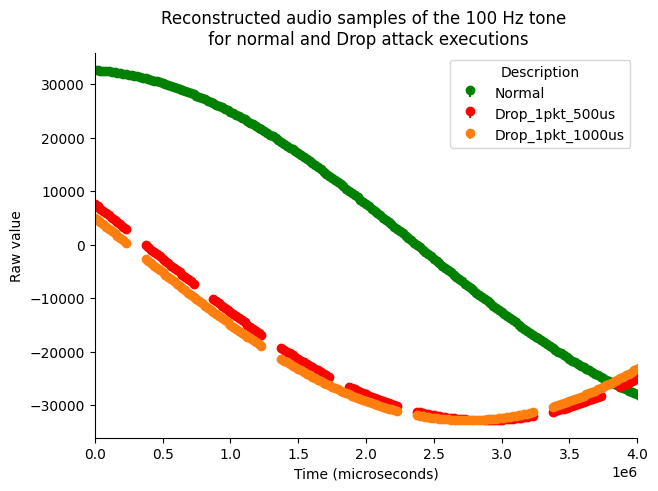

In [ ]:
n_rows = 1
fig3, axes3 = plt.subplots(n_rows, 1, figsize=(7, (n_rows)*5))

normal_filter = {
    description_name: ["Normal", "Drop_1pkt_500us", "Drop_1pkt_1000us"]
}

dropped_filtered = filter_dataframe(combined_channels_df, normal_filter)
n_samples = 200
group = dropped_filtered.groupby(description_name)

def sample_group(group):
  return group[0:n_samples]

sampled_filtered = group.apply(sample_group)
sampled_filtered = sampled_filtered.reset_index(drop=True)

(markerline, stemlines, baseline) = plt.stem(sampled_filtered[sampled_filtered[description_name] == "Normal"]['updated_shifted_ts'], sampled_filtered[sampled_filtered[description_name] == "Normal"]['channel_0_int'], label='Normal', linefmt='g-', markerfmt='go', basefmt=' ')
stemlines.set_visible(False)
(markerline, stemlines, baseline) = plt.stem(sampled_filtered[sampled_filtered[description_name] == "Drop_1pkt_500us"]['updated_shifted_ts'], sampled_filtered[sampled_filtered[description_name] == "Drop_1pkt_500us"]['channel_0_int'], label='Drop_1pkt_500us', linefmt='r-', markerfmt='ro', basefmt= ' ')
stemlines.set_visible(False)
(markerline, stemlines, baseline) = plt.stem(sampled_filtered[sampled_filtered[description_name] == "Drop_1pkt_1000us"]['updated_shifted_ts'], sampled_filtered[sampled_filtered[description_name] == "Drop_1pkt_1000us"]['channel_0_int'], label='Drop_1pkt_1000us', linefmt='C1-', markerfmt='C1o', basefmt=' ')
stemlines.set_visible(False)

# axes3 = sns.scatterplot(data=dropped_filtered, x='relative_updated_ts', y='channel_0_int', hue=description_name, style=description_name, linewidth=2)
# axes3.set(xlabel='Time (miliseconds)', ylabel='Packets per ms')
# axes3.set_ylim(-5, +5)
axes3.spines['right'].set_visible(False)
axes3.spines['top'].set_visible(False)
# axes3.set_title(f"Packets per ms interval in normal and Drop attack runs")
axes3.set_xlim(0, 4e+06)
axes3.set_title("Reconstructed audio samples of the 100 Hz tone \n for normal and Drop attack executions")
axes3.set_ylabel("Raw value")
axes3.set_xlabel("Time (microseconds)")
plt.legend(title=description_name)

In [ ]:
sampled_filtered[sampled_filtered[description_name] == "Drop_1pkt_1ms"]['updated_shifted_ts']

0      0.000000e+00
1      2.083333e+04
2      4.166667e+04
3      6.250000e+04
4      8.333333e+04
           ...     
295    7.020833e+06
296    7.041667e+06
297    7.062500e+06
298    7.083333e+06
299    7.104167e+06
Name: updated_shifted_ts, Length: 300, dtype: float64

In [ ]:
dropped_filtered[0:300][description_name].unique()

array(['Normal', 'Drop_1pkt_500us', 'Drop_1pkt_1ms'], dtype=object)

In [ ]:
result

,0,1,2,3,shifted_ts,updated_shifted_ts,channel_0_int,channel_1_int,Run description
0,0,1790599752,1405,3fff,0,0.000000e+00,5125,16383,Drop_1pkt_1ms
1,1,1790599752,125d,30fb,0,2.083333e+04,4701,12539,Drop_1pkt_1ms
2,2,1790599752,10b4,2120,0,4.166667e+04,4276,8480,Drop_1pkt_1ms
3,3,1790599752,0f0b,10b4,0,6.250000e+04,3851,4276,Drop_1pkt_1ms
4,4,1790599752,0d61,0000,0,8.333333e+04,3425,0,Drop_1pkt_1ms
...,...,...,...,...,...,...,...,...,...
895,1,1701852624,a6b0,30fb,6125000,6.145833e+06,-22864,12539,Normal
896,2,1701852624,a7e5,2120,6125000,6.166667e+06,-22555,8480,Normal
897,3,1701852624,a91e,10b4,6125000,6.187500e+06,-22242,4276,Normal
898,4,1701852624,aa5b,0000,6125000,6.208333e+06,-21925,0,Normal
